In [2]:
import tensorflow as tf
import numpy as np
import os
import time

2024-12-28 18:22:56.644753: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-28 18:22:57.002802: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-12-28 18:22:57.002851: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-12-28 18:22:58.166595: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

### SOURCE TEXT LOADING
- loading .txt
- printing the beginning, number of characters, number of unique characters
    

In [3]:
with open("ring.txt", "r") as f:
    source = f.read()
print(source[:300])

THE  FELLOWSHIP 
OF  THE  RING 


BEING  THE  FIRST  PART 
OF 

The  Lord  of  the  Rings 


BOOK  ONE 


Chapter  I 


A  LONG-EXPECTED  PARTY 


When  Mr.  Bilbo  Baggins  of  Bag  End  announced  that  he 
would  shortly  be  celebrating  his  eleventy-first  birthday  with 
a  party  of  special


In [4]:
print ('{} characters'.format(len(source)))

1145534 characters


In [5]:
vocab = sorted(set(source))
print ('{} unique characters'.format(len(vocab)))

88 unique characters


In [6]:
# unique characters to indices mapping
char2index = {u:i for i, u in enumerate(vocab)}
index2char = np.array(vocab)

text_as_int = np.array([char2index[c] for c in source])

print(text_as_int)

[45 33 30 ...  1  0  0]


In [7]:
print ('{} -- characters mapped to int -- > {}'.format(repr(source[:13]), text_as_int[:13]))

'THE  FELLOWSH' -- characters mapped to int -- > [45 33 30  1  1 31 30 37 37 40 48 44 33]


### DATASET PREPROCESSING
- character to index mapping and converting text to numerical representation
- defining max input sequence length
- creating TensorFlow Dataset from the source
- creating batches from dataset
- input-target split function (:-1 is input, and last element is expected value)
- applying input-target split function to each batch

In [8]:
seq_length = 100
examples_per_epoch = len(source)//(seq_length+1)

char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
  print(index2char[i.numpy()])


T
H
E
 
 


2024-12-28 18:23:01.549537: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-12-28 18:23:01.549640: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-12-28 18:23:01.549694: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-12-28 18:23:01.549743: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2024-12-28 18:23:01.549787: W tensorfl

In [9]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
  print(repr(''.join(index2char[item.numpy()])))

'THE  FELLOWSHIP \nOF  THE  RING \n\n\nBEING  THE  FIRST  PART \nOF \n\nThe  Lord  of  the  Rings \n\n\nBOOK  ON'
'E \n\n\nChapter  I \n\n\nA  LONG-EXPECTED  PARTY \n\n\nWhen  Mr.  Bilbo  Baggins  of  Bag  End  announced  tha'
't  he \nwould  shortly  be  celebrating  his  eleventy-first  birthday  with \na  party  of  special  m'
'agnificence,  there  was  much  talk  and \nexcitement  in  Hobbiton. \n\nBilbo  was  very  rich  and  v'
'ery  peculiar,  and  had  been  the \nwonder  of  the  Shire  for  sixty  years,  ever  since  his  re'


In [10]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

### PARAMETERS
- training parameters & data shuffling
- model hyperparameters

In [11]:
BATCH_SIZE = 2048
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset element_spec=(TensorSpec(shape=(2048, 100), dtype=tf.int64, name=None), TensorSpec(shape=(2048, 100), dtype=tf.int64, name=None))>

In [12]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 300 #256

# Number of RNN units
rnn_units1 = 256
rnn_units2 = 256
rnn_units=[rnn_units1, rnn_units2]
print(vocab_size)

88


### BUILDING MODEL
- GRU, LSTM, RNN, with Conv1

In [13]:
# ORIGINAL GRU
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(rnn_units1,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.GRU(rnn_units2,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [14]:
# # LSTM
# def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
#     model = tf.keras.Sequential([
#         tf.keras.layers.Embedding(vocab_size, embedding_dim, 
#                                   batch_input_shape=[batch_size, None]),
#         tf.keras.layers.LSTM(rnn_units1,
#                              return_sequences=True,
#                              stateful=True,
#                              recurrent_initializer='glorot_uniform'),
#         tf.keras.layers.LSTM(rnn_units2,
#                              return_sequences=True,
#                              stateful=True,
#                              recurrent_initializer='glorot_uniform'),
#         tf.keras.layers.Dense(vocab_size)
#     ])
#     return model

In [15]:
# # RNN
# def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
#     model = tf.keras.Sequential([
#         tf.keras.layers.Embedding(vocab_size, embedding_dim, 
#                                   batch_input_shape=[batch_size, None]),
#         tf.keras.layers.SimpleRNN(rnn_units1,
#                                   return_sequences=True,
#                                   stateful=True,
#                                   recurrent_initializer='glorot_uniform'),
#         tf.keras.layers.SimpleRNN(rnn_units2,
#                                   return_sequences=True,
#                                   stateful=True,
#                                   recurrent_initializer='glorot_uniform'),
#         tf.keras.layers.Dense(vocab_size)
#     ])
#     return model


In [16]:
# # dodanie Conv1
# def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
#     model = tf.keras.Sequential([
#         tf.keras.layers.Embedding(vocab_size, embedding_dim, 
#                                   batch_input_shape=[batch_size, None]),
#         tf.keras.layers.Conv1D(filters=128, 
#                                kernel_size=5, 
#                                activation='relu', 
#                                padding='same'),
#         tf.keras.layers.GRU(rnn_units1,
#                             return_sequences=True,
#                             stateful=True,
#                             recurrent_initializer='glorot_uniform'),
#         tf.keras.layers.GRU(rnn_units2,
#                             return_sequences=True,
#                             stateful=True,
#                             recurrent_initializer='glorot_uniform'),
#         tf.keras.layers.Dense(vocab_size)
#     ])
#     return model


In [17]:
model = build_model(
  vocab_size = vocab_size,
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (2048, None, 300)         26400     
                                                                 
 gru (GRU)                   (2048, None, 256)         428544    
                                                                 
 gru_1 (GRU)                 (2048, None, 256)         394752    
                                                                 
 dense (Dense)               (2048, None, 88)          22616     
                                                                 
Total params: 872,312
Trainable params: 872,312
Non-trainable params: 0
_________________________________________________________________


### MODEL TRAINING
- optimizer & loss function declaration
- compilation
- epochs number
- launching the training

In [19]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [20]:
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

In [21]:
checkpoint_dir = './checkpoints_GRU'        # TODO: remember to choose proper directory
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [22]:
EPOCHS=5

In [23]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/5


5/5 [==============================] - 27s 5s/step - loss: 4.2794 - accuracy: 0.2457
Epoch 2/5
5/5 [==============================] - 26s 5s/step - loss: 3.4697 - accuracy: 0.3008
Epoch 3/5
5/5 [==============================] - 26s 5s/step - loss: 3.1727 - accuracy: 0.3009
Epoch 4/5
5/5 [==============================] - 24s 5s/step - loss: 2.9621 - accuracy: 0.3009
Epoch 5/5
5/5 [==============================] - 28s 6s/step - loss: 2.9341 - accuracy: 0.3008


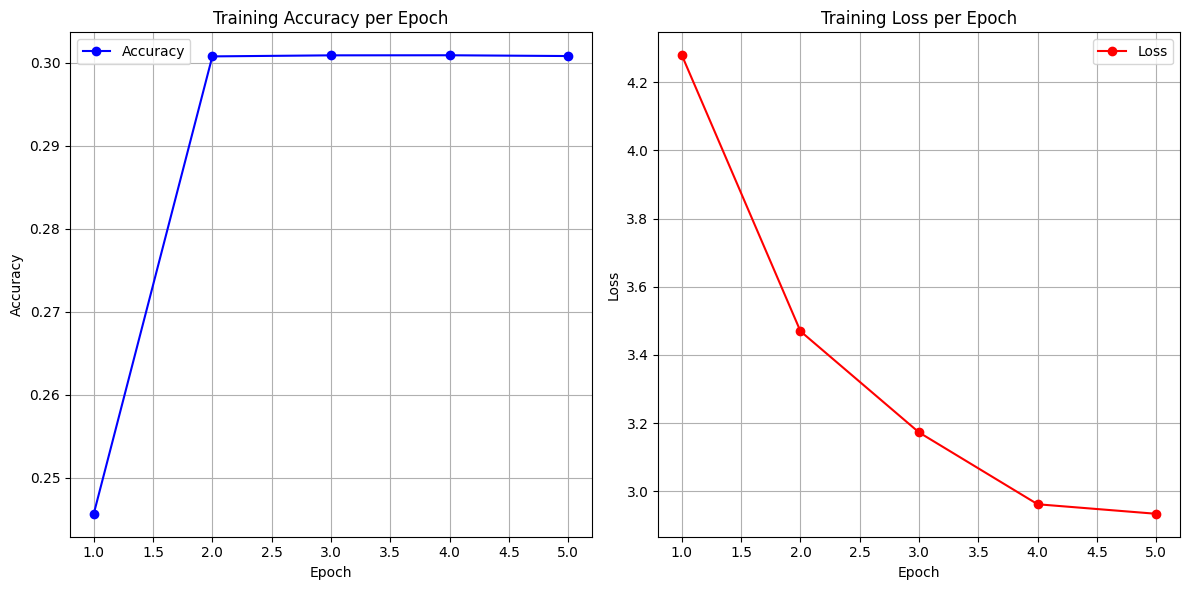

In [24]:
import matplotlib.pyplot as plt

# Pobranie wartości strat i dokładności z historii
loss = history.history['loss']
accuracy = history.history['accuracy']
epochs = range(1, len(loss) + 1)

# Wykres strat i dokładności
plt.figure(figsize=(12, 6))

# Wykres strat
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, marker='o', label='Accuracy', color='blue')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Wykres dokładności
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, marker='o', label='Loss', color='red')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


### RESULTS
- bulding the model and applying saved weights
- text generation function
- generate text based on the provided beginning

In [25]:
latest_check= tf.train.latest_checkpoint(checkpoint_dir)

In [26]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(latest_check)

model.build(tf.TensorShape([1, None]))

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (1, None, 300)            26400     
                                                                 
 gru_2 (GRU)                 (1, None, 256)            428544    
                                                                 
 gru_3 (GRU)                 (1, None, 256)            394752    
                                                                 
 dense_1 (Dense)             (1, None, 88)             22616     
                                                                 
Total params: 872,312
Trainable params: 872,312
Non-trainable params: 0
_________________________________________________________________


In [28]:
def generate_text(model, start_string):

  num_generate = 1000
  input_eval = [char2index[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)
  text_generated = []
  scaling = 0.5

  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      predictions = tf.squeeze(predictions, 0)
      predictions = predictions / scaling
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      input_eval = tf.expand_dims([predicted_id], 0)
      text_generated.append(index2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [29]:
print(generate_text(model, start_string=u"Harry killed Ron "))

Harry killed Ron  e  e  s e   a       e  eii                           a h    e      ra    a h    e              e se t ea r       i  n   aa   e n              d       i   d   l       e ie       s  r         r             h  
e   t    am          ld  a      l   s n  gde    t n ae        w   ad n e i s  ss         s  d l       lee i   a  s  stt         a  oi   h s e     e srgt  ae  o  a    e      d  ,edr     n o  inm   enia ai  a r s t  dh                              an    d   u a    i  hi    e      wo      r              ss   o t   a a u selelndas 
 rn    tr     a             n e e       pt  
  n     r l        o a  etdh s      le   on     il     e s ru e e     l n   l  as na     ll y    he ee          a   es  i   ta  h             a  d      n  m    le
e   i d   d    r d          n a  rn   e  u     s n   e       i  o  ra tn     h d t  a  h        r    e o         n       a   e amor es e i      ln  a 
 o  ms h   e    n   t i e      a          w      
e      a  s  ed         l   
e
    

In [30]:
print(generate_text(model, start_string=u"Manchaster Uniter just lost the war on Anfield fighting"))

Manchaster Uniter just lost the war on Anfield fighting m  ad  ertw       s      ud e  s  h  in  r        t      e  a    hag    e      e or    r    et    a i e        l  e                  e er     l y     t  t       i  r  o          att       ewas      n     e      n  h w a o       n  t    ,h      m    ae            nsa      . d     d     y  e      h  r n  e     a e  yild   s  ie   d   edd neg   l rae a  te   a i     se a       h       ede a l     eh  a  anr  d eh   e    ee   nlea d   o      i         e   n dt   s      at  e  emi   e  s          tfe      r  d sh       so    n   ae e            dett            e s  es   
  r    a   o e   i   i           e  n n d sdt  oe   i         o      f        i e      s     ie i m         iops  e  t      s    
  
 e      wt   u  e          a
  l os    d an     a    r   r d e  a n r  e   si     es rl uee de      n   s     i e id e     e      it m   el         n  re          n m   n   se   a s   nn  r  ye  n e  c  y         e    t i.  y.    w  e  i 

---

In [31]:
def calculate_cross_entropy_loss(model, test_sequences):
    total_loss = 0
    total_steps = 0
    
    for sequence in test_sequences:
        input_seq = sequence[:-1]
        target_seq = sequence[1:]
        
        input_seq = tf.expand_dims(input_seq, 0)
        
        predictions = model(input_seq)
        
        loss = tf.keras.losses.sparse_categorical_crossentropy(target_seq, predictions[0], from_logits=True)
        
        total_loss += tf.reduce_sum(loss).numpy()
        total_steps += len(target_seq)
    
    avg_loss = total_loss / total_steps
    return avg_loss

In [32]:
# tutaj można załadować inną część tolkiena albo hobbita
first_10_sequences = list(sequences.take(2))

In [33]:
avg_loss = calculate_cross_entropy_loss(model, first_10_sequences)
avg_loss

4.331626892089844

In [41]:
perplexity = np.exp(avg_loss)
perplexity

28.892457089374666

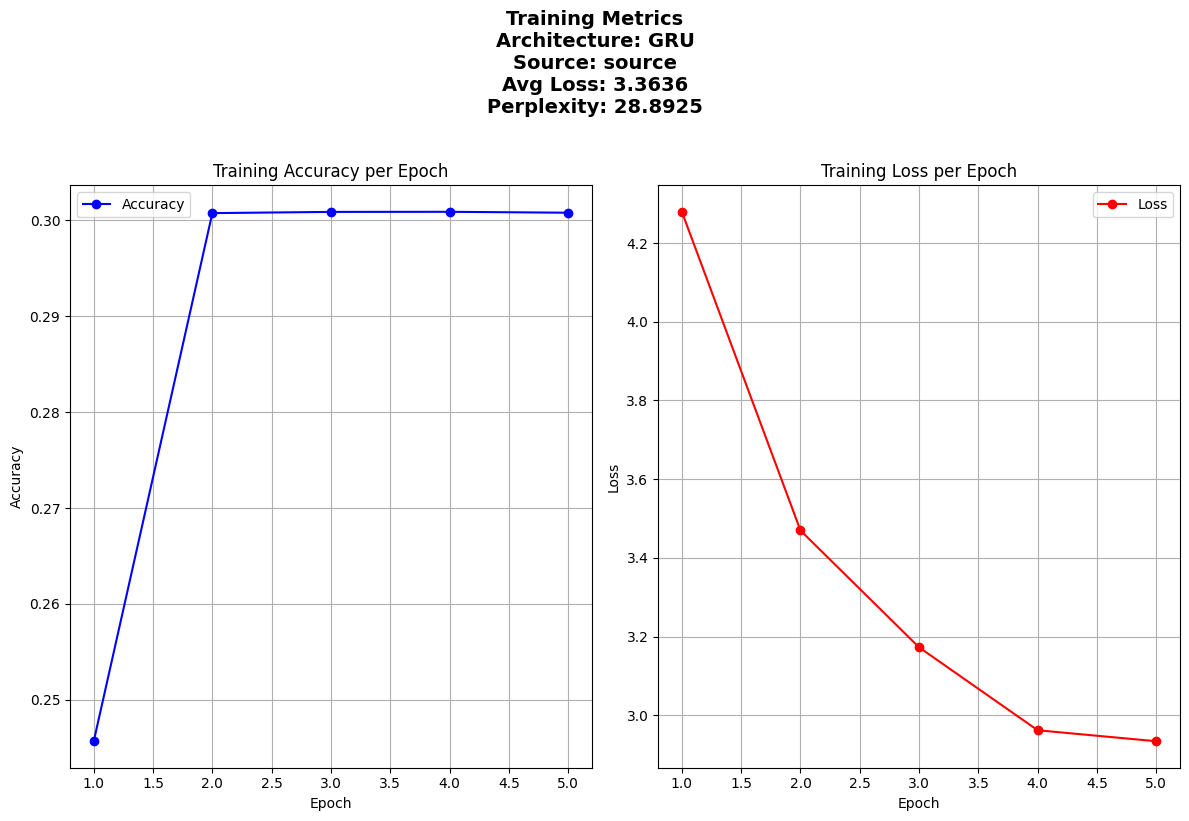

In [ ]:
import matplotlib.pyplot as plt

# Pobranie wartości strat i dokładności z historii
loss = history.history['loss']
accuracy = history.history['accuracy']
epochs = range(1, len(loss) + 1)

# Informacje do wyświetlenia
architecture = "GRU"
source_text = "source"
info_text = f"Architecture: {architecture}\nSource: {source_text}\nAvg Loss: {avg_loss:.4f}\nPerplexity: {perplexity:.4f}"

# Wykres strat i dokładności
plt.figure(figsize=(12, 8))

# Tytuł wykresu z informacjami
plt.suptitle(f"Training Metrics\n{info_text}", fontsize=14, fontweight='bold', y=1.02)

# Wykres dokładności
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, marker='o', label='Accuracy', color='blue')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Wykres strat
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, marker='o', label='Loss', color='red')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()


plt.tight_layout()
plt.show()


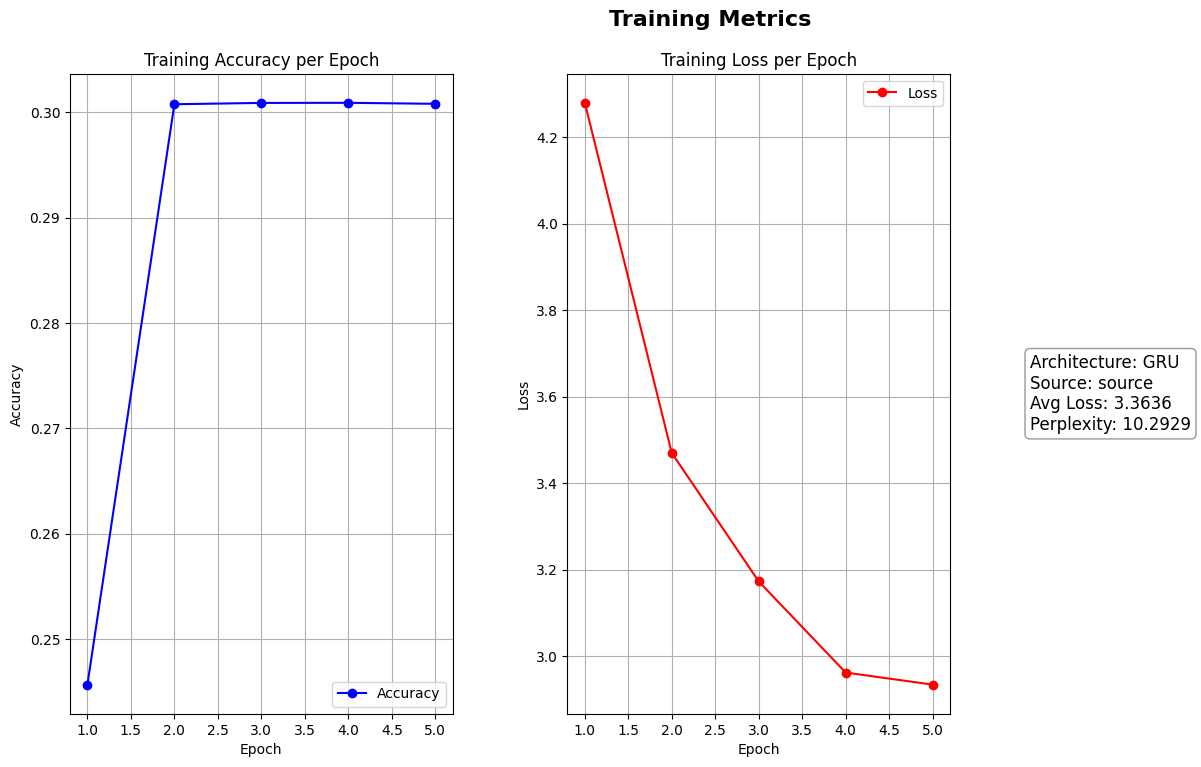

In [44]:
import matplotlib.pyplot as plt

# Pobranie wartości strat i dokładności z historii
loss = history.history['loss']
accuracy = history.history['accuracy']
epochs = range(1, len(loss) + 1)

# Informacje do wyświetlenia
architecture = "GRU"
source_text = "source"
avg_loss = sum(loss) / len(loss)  # Średnia strat
perplexity = 2 ** avg_loss  # Przykład obliczenia perplexity
info_text = f"Architecture: {architecture}\nSource: {source_text}\nAvg Loss: {avg_loss:.4f}\nPerplexity: {perplexity:.4f}"

# Tworzenie figury i wykresów
fig, axes = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.3})

# Tytuł na środku
fig.suptitle("Training Metrics", fontsize=16, fontweight='bold')

# Wykres dokładności
axes[0].plot(epochs, accuracy, marker='o', label='Accuracy', color='blue')
axes[0].set_title('Training Accuracy per Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].grid(True)
axes[0].legend()

# Wykres strat
axes[1].plot(epochs, loss, marker='o', label='Loss', color='red')
axes[1].set_title('Training Loss per Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].grid(True)
axes[1].legend()

# Dodanie informacji w pustej przestrzeni (poza wykresami)
fig.text(0.7, 0.5, info_text, fontsize=12, va='center', ha='left',
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle="round"))

# Dostosowanie marginesów, aby uniknąć nachodzenia
plt.subplots_adjust(left=0.1, right=0.65, top=0.9, bottom=0.1)

# Wyświetlanie wykresu
plt.show()
